In [1]:
import time, sys, joblib, os

sys.path.append('/home/yilingh/SI-Interaction')
import multiprocessing as mp

from selectinf.Simulation.simulation_helpers import calculate_F1_score_main
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [2]:
def predict(beta_hat, X_test):
    return X_test.dot(beta_hat)

def generate_test(Y_mean, noise_sd):
    n = Y_mean.shape[0]
    Y_test = Y_mean + np.random.normal(size=(n,), scale=noise_sd)

    return Y_test

In [106]:
def toy_example(start, end, noise_sd=3):
    MSE_dict = {}
    MSE_dict["MSE"] = []
    MSE_dict["method"] = []
    MSE_dict["prop"] = []

    F1_dict = {}
    F1_dict["F1"] = []
    F1_dict["method"] = []
    F1_dict["prop"] = []

    # A dictionary recording p-values for each true interaction
    # over all simulation results.
    # Each simulation parameter (here parameter_list contain a list of main signal strengths
    # to be considered) has a corresponding dictionary of results
    parameter_list = np.array([0.5, 0.6, 0.7, 0.8, 0.9])  # np.array([0.02, 0.04, 0.06])#np.array([10, 5, 2, 1])
    pval_dict = {}
    for x in parameter_list:
        pval_dict[x] = {}
        for m in ['Naive', 'Data Splitting', 'MLE']:
            pval_dict[x][m] = []

    # Group lasso solver constructor
    const = group_lasso.gaussian
    active_inter_list_true = np.array([[0, 1], [1, 2], [2, 4], [1, 5], [2, 6]])
    active_inter_list_true_list = [(x[0], x[1]) for x in active_inter_list_true]

    # p = 50
    rho = 0.5#6  # Correlation of signal covariates (amongst themselves), and noise.
    sig = 2    # Controlling interaction vs main signals.
    # Setting it this way generates comparable main
    # and interaction signals (sig = 2 works )
    weights = 3  # Group Lasso weights
    s_inter = 5  # Number of true interactions
    p_nl = 20  # Number of nonlinear covariates
    n = 200
    root_n_scaled = False
    main_sig = 2

    ds_rank_def_count = {prop: 0 for prop in parameter_list}
    ds_no_select_count = {prop: 0 for prop in parameter_list}

    for prop in parameter_list:
        for i in range(start, end):
            np.random.seed(i + 1000)
            # MSE_set = False

            print(prop, i, "th simulation done")
            print("seed:", i + 1000)
            # Generating a (X, Y) pair, and corresponding basis expansion
            # The 'weakhierarchy' argument is overridden by setting
            # `active_inter_list`.
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=n, p_nl=p_nl, rho=rho, full_corr=False, rho_noise=rho,
                    block_corr=True, rho_cross=rho * 0.8,
                    SNR=None, main_signal=main_sig, noise_sd=noise_sd,
                    nknots=6, degree=2, interaction_signal=sig,
                    random_signs=False, scale=root_n_scaled, center=False,
                    structure='weakhierarchy', s_interaction=s_inter,
                    intercept=True, active_inter_list=active_inter_list_true,
                    return_gamma=True))
            design *= np.sqrt(design.shape[0])
            design[:, 0] = 1
            print("SD(Y): ", np.std(Y))
            Y_test = Y_mean + np.random.normal(size=(n,), scale=noise_sd)

            # Performing Naive inference using 'all pairs'
            (_, selected_groups, beta_hat_naive) \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9, mode='weakhierarchy',
                                        solve_only=True, continued=False,
                                        parallel=False, p_val=True,
                                        return_pivot=True, intercept=True,
                                        target_ids=None,
                                        root_n_scaled=root_n_scaled)
            print(selected_groups)

            # Continue if Naive yields a nonempty group lasso selection
            # (this is almost always the case)
            # Performing data splitting using 'all pairs'
            # DS solve only
            ds_rank_def = False
            (nonzero_ds, selected_groups_ds, subset_select_ds, beta_hat_ds) \
                = data_splitting_inter(X=design, Y=Y, groups=groups,
                                       Y_mean=Y_mean, const=const,
                                       n_features=20, interactions=data_interaction,
                                       proportion=prop,
                                       weight_frac=weights, level=0.9,
                                       mode='weakhierarchy',
                                       solve_only=True, continued=False,
                                       parallel=False, p_val=True,
                                       target_ids=None, intercept=True,
                                       root_n_scaled=root_n_scaled)
            print(selected_groups_ds)
            if nonzero_ds.sum() + 1 >= n - subset_select_ds.sum():
                ds_rank_def = True
                ds_rank_def_count[prop] += 1
            if nonzero_ds.sum() == 1:
                ds_no_select_count[prop] += 1

            # Continue if data splitting yields a nonempty group lasso selection
            # (this is almost always the case)
            # Performing MLE using 'all pairs'
            (a, b, selected_groups_MLE, beta_hat_MLE) \
                = (MLE_inference_inter
                   (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                    n_features=p_nl, interactions=data_interaction,
                    intercept=True,
                    # randomizer_sd_const=tau,
                    proportion=prop,
                    weight_frac=weights,
                    level=0.9, mode='weakhierarchy', solve_only=True,
                    continued=False, parallel=False, p_val=True,
                    target_ids=None,
                    root_n_scaled=root_n_scaled))
            print(selected_groups_MLE)

            # Set MSE
            MSE_naive = np.mean((Y_test - predict(beta_hat_naive, design)) ** 2)
            MSE_dict["MSE"].append(MSE_naive)
            MSE_dict["method"].append("Naive")
            MSE_dict["prop"].append(prop)

            MSE_ds = np.mean((Y_test - predict(beta_hat_ds, design)) ** 2)
            MSE_dict["MSE"].append(MSE_ds)
            MSE_dict["method"].append("Data Splitting")
            MSE_dict["prop"].append(prop)

            MSE_MLE = np.mean((Y_test - predict(beta_hat_MLE, design)) ** 2)
            MSE_dict["MSE"].append(MSE_MLE)
            MSE_dict["method"].append("MLE")
            MSE_dict["prop"].append(prop)

            # Set F1
            F1_naive = calculate_F1_score_main(selected=selected_groups, true=[1,2,3])
            F1_dict["F1"].append(F1_naive)
            F1_dict["method"].append("Naive")
            F1_dict["prop"].append(prop)

            F1_ds = calculate_F1_score_main(selected=selected_groups_ds, true=[1,2,3])
            F1_dict["F1"].append(F1_ds)
            F1_dict["method"].append("Data Splitting")
            F1_dict["prop"].append(prop)

            F1_MLE = calculate_F1_score_main(selected=selected_groups_MLE, true=[1,2,3])
            F1_dict["F1"].append(F1_MLE)
            F1_dict["method"].append("MLE")
            F1_dict["prop"].append(prop)
    
    return MSE_dict, F1_dict, ds_rank_def_count, ds_no_select_count

In [107]:
MSE_dict, F1_dict, ds_rank_def_count, ds_no_select_count = toy_example(0, 100)

0.5 0 th simulation done
seed: 1000
Equally spaced quantile knots used.
Main: 1.4565847106005996
Interaction: 2.286671177228378
induced SNR: 1.3329558290504147
SD(Y):  4.792479365950481
Naive weights: 348.79523184968355
[0, 1, 2, 3]
Data splitting 0.5 weights: 268.4399183359842
[0]
Data Carving Randomization Used
[0, 2]
0.5 1 th simulation done
seed: 1001
Equally spaced quantile knots used.
Main: 1.363413060316338
Interaction: 2.198183832102281
induced SNR: 1.1619196281754607
SD(Y):  4.064719532310498
Naive weights: 323.62015483528944
[0, 1, 2]
Data splitting 0.5 weights: 253.74312753964483
[0]
Data Carving Randomization Used
[0, 1, 2]
0.5 2 th simulation done
seed: 1002
Equally spaced quantile knots used.
Main: 1.4048198763722177
Interaction: 2.3076293748767034
induced SNR: 1.2508603494002308
SD(Y):  4.559229754174034
Naive weights: 350.0035018429472
[0, 2]
Data splitting 0.5 weights: 258.13830632291354
[0, 2]
Data Carving Randomization Used
[0, 2]
0.5 3 th simulation done
seed: 1003


In [108]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })

Text(0, 0.5, 'Test MSE')

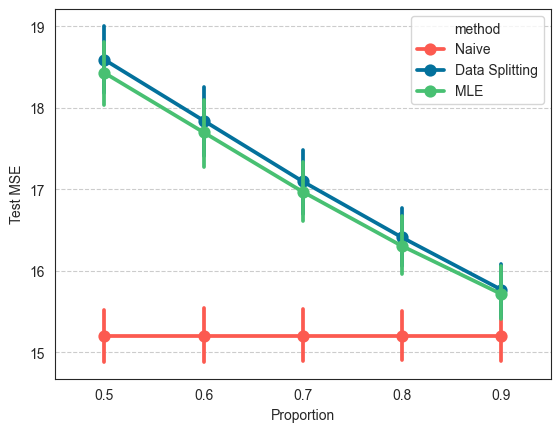

In [109]:
sns.pointplot(x=pd.DataFrame(MSE_dict)["prop"],
              y=pd.DataFrame(MSE_dict)["MSE"],
              hue=pd.DataFrame(MSE_dict)["method"], markers='o',
              palette=my_palette)
#plt.ylim(25,30)
plt.xlabel(r"Proportion")
plt.ylabel("Test MSE")

Text(0, 0.5, 'F1 score')

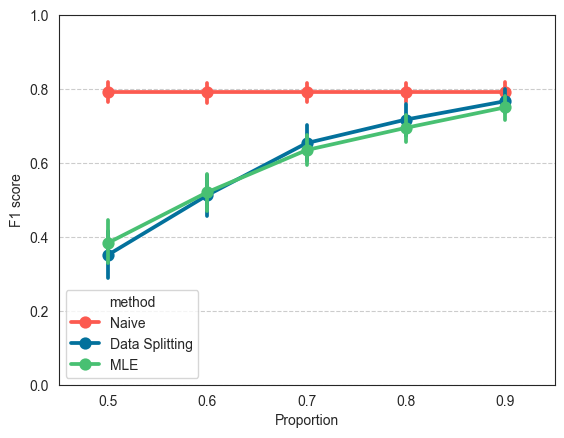

In [110]:
sns.pointplot(x=pd.DataFrame(F1_dict)["prop"],
              y=pd.DataFrame(F1_dict)["F1"],
              hue=pd.DataFrame(F1_dict)["method"], markers='o',
              palette=my_palette)
plt.ylim(0.,1)
plt.xlabel(r"Proportion")
plt.ylabel("F1 score")

In [99]:
ds_rank_def_count

{0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}

In [100]:
ds_no_select_count

{0.5: 3, 0.6: 3, 0.7: 0, 0.8: 0, 0.9: 0}

In [10]:
from scipy.stats import multivariate_normal

In [125]:
multivariate_normal.pdf([1,1], mean=[0,0], cov=[[1,0], [0,1]])

0.05854983152431917